# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In this assignment I perform Linear Kernel with all the below steps:-


1. Data reading
2. Exploratory Data Analysis
3. Text Preprocessing on Review text data and Summary data
4. Sample data of 80k datapoints from dataset and do time based splitting
5. Perform Linear Kernel using SGDClassifier with hinge loss with both L1 and L2 regularization, on all 4 featurizations BoW, TFIDF, Avg-W2V, TFIDF-W2V.
6. Using AUC as a metric for hyperparameter tuning
7. Finding top 10 important features for each of the positive and negative classes on the linear kernel with BOW and TFIDF 
8. Documenting the results    

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [149]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [150]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [5]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [6]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [7]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-

From the above output we can see that there are many positive reviews and fewer negative reviews.


#  [3] Text  Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1].  Preprocessing Review Text


In [8]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [9]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [10]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [11]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [13]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [14]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [16]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [02:56<00:00, 2059.08it/s]


In [19]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [20]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [21]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [22]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2] Preprocessing Reviews Summary

In [23]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [24]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [25]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [27]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [28]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [02:11<00:00, 2778.34it/s]


In [31]:
summary_data[56000]

'awesome yummy'

In [32]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [33]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [34]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


# 4. Sample the data from the Dataset

Due to long computation time and less computation power of my laptop, I am taking 80k points instead of 100k points.


In [35]:
# Taking equal sample of negative and positive reviews each 40000, total 80,000 datapoints
positive_pts = final_data[final_data['Score'] == 1].sample(n=40000)
negative_pts = final_data[final_data['Score'] == 0].sample(n=40000)

# Concatenating both positive and negative points
total_score = pd.concat([positive_pts, negative_pts])
total_score.shape


(80000, 12)

## [4.1] Time Based Splitting

Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Cross Validate data is used to find best hyper parameter and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.



In [36]:
# sorting data using time
total_score['Time'] = pd.to_datetime(total_score['Time'])
total_score = total_score.sort_values(by = 'Time', ascending = True)


In [37]:
# display top 5 rows
total_score.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,1970-01-01 00:00:00.948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",always enjoyed movie funny entertaining not he...,warning clamshell edition edited tv version
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,1970-01-01 00:00:00.951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happens say name three times michael keaten st...,bettlejuicebettlejuicebettlejuice
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,1970-01-01 00:00:00.962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,wow make islickers
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,1970-01-01 00:00:00.970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,beetlejuice aweinspiring wonderfully amusing c...,fabulous comedic fanasy directed master


### [4.2] Splitting data into Train and Test data

In [38]:
# splitting the data into train, test data
from sklearn.cross_validation import train_test_split
X = total_score['CleanedText']
Y = total_score['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)


X_train, Y_train (56000,) (56000,)
X_test, Y_test (24000,) (24000,)


# Support Vector Machines (SVM)

1. SVM is a popular Machine Learning technique for both Classification and Regression techniques.
2. The key idea of SVM is, to find a hyperplane that seperates positive points from negative points as widely as possible. Such a hyperplane is called margin maximizing hyperplane. The wider the distance of positive and negative points from the hyperplane, the better it is.
3. So SVM's try to find a hyperplane that maximizes the margin, where margin is the distance between the positive hyperplane and negative hyperplane. Positive hyperplane is a plane that is parallel to seperating hyperplane and it touches the first positive data point. Negative hyperplane is a plane that touches the first negative data point and is parallel to seperating hyperplane that divides both positive and negative data points.
4. If the distance of margin between poth positive and negative points is high, then the chance of misclassification of points will decrease. So as margin distance increase, the generalization accuracy (which is the accuracy on unseen data points in future) will increase.
5. So SVM's will always try to maximize the margin.

##### Support Vector:-

1. Points through which positive and negative hyperplanes pass through or points which are on positive and negative hyperplanes, are called support vectors.
2. For any given new data points to determine whether it is positive or negative, we use actual seperating hyperplane/margin maximizing hyperplane. We use postive and negative hyperplanes to maximize the margin distance between positive and negative points.

##### Alternative interpretation of SVM :-

1. Construct a convex-hull for positive points and negative points seperately.
2. Find the shortest line connecting these convex-hulls.
3. Bisect/Break the line into 2 equal parts with equal length, then the plane that bisects this line is called margin maximizing hyperplane.

##### Hard-Margin SVM:-

We have to find W and b that maximizes the margin length, such that for each data point 'i', Yi(W^T Xi+b)>=1. This is the constraint optimization problem of SVM. This works when the data is linearly seperable. Here the constraints are, all the positive points should be on one side and negative points on one side and there should not be any points in the margin area between positive and negative points. This is Hard-margin SVM.

1. We can't apply above constraint optimization problem for not-linearly seperable data/almost linearly seperable. We can't find W and b that satisfies the above constraint. It will never satisfy the above constraints.
2. In such cases we create new variable called zeta. For all the misclassified points zeta_i is >=0 and the points are some units of distance away from the correct hyperplane.
3. As the zeta_i increases, we can know that point is farther away from the correct hyperplane in the incorrect direction . Zeta_i for correctly classified points (Yi(W^T Xi+b)>=1) is equal to 0.
4. So for all the points zeta_i is positive or equal to 0.
5. We introduce a hyperparameter 'C', where as C increases, the tendency to make mistakes reduces on training data which means we are overfitting the training data/high-variance model. As the C decreases, we have a tendency to underfit/high-bias model. Hyperparameter C in SVM behaves exactly opposite to lambda in Logistic regression
6. Soft-margin SVM allows errors but errors should be minimized.

##### Hinge-loss:-

1. Hinge-loss + regularization we get SVM. For Zi>=1, hinge-loss = 0. For Zi<1, hinge-loss = 1-Zi.
2. Zeta_i and Hinge loss are = 0 for correctly classified points. Zeta_i > 0 for incorrectly classified points.

Soft-margin SVM is called Primal of SVM. Support vectors are the only ones that matters for classification. Non support vectors doesn't change the function much.

SVM is always done in Dual form because implementing similarity matrix is easy in Dual form - K(Xi, Xj). We can't easily implement it in Primal form SVM beacuse we need Xi's and Xj's explicitly. SVM became popular for this reason.

##### Kernel trick:-

1. In K(Xi, Xj), K is the kernel function, which tells the similarity between Xi and Xj. Xi^T.Xj can be replaced by any similarity function and one class of similarity function are kernels and so it is replaced by kernel function K(Xi,Xj). This is called Kernel trick
2. The most important idea in SVM is Kernel trick/Kernelization.
3. If we don't do Kernel trick in SVM then it is called Linear SVM. If we do the kernel trick where (Xi^T.Xj) is replaced with K(Xi,Xj) then it is called Kernel SVM.
4. In Linear SVM we are trying to find Margin maximizing hyperplane in Xi's. But it may fial in cases where we can't seperate the data points with a hyperplane. Logistic-regression with feature transforms can work in this case. But kernel SVM will succeed in this case with a right kernel.
5. Kernel SVM transforms features from and Xi to Xi' and in this space it finds a hyperplane. In Kernel SVM, using kernel trick we can solve non-linearly seperable data also.
6. So kernelization allows SVM to handle non-linearly seperable data also.

##### Polynomial kernel:-

1. Given 2 datapoints/vectors X1 and X2- K(X1,X2), the polynomial kernel is (X1^T X2+C)^d where C and d are constants. Quadratic kernel is (1+X1^T X2)^2. Kernelization is same as feature transform.
2. Kernelization takes data which is d-dim and non linearly seperable and does feature transform internally/implicitly of data to a different higher dimension/space d' where d'>d, and here in this new dimension data is in the square forms and can be seperated by hyperplanes/linearly seperable.
3. A theorem called Mercer's theorem says kernel trick internal implementation
4. So the feature transformation which is done explicitly in Logistic regression is replaced by kernelization/kernel trick in SVM, the important thing we have to do is, to find the right kernel to do kernel trick in SVM.

##### RBF-Kernel:-

1. Radial Basis Function (RBF) is the most-popular and general-purpose kernel in SVM because of its similarity to KNN.
2. In RBF kernel, the distance between the points X1 and X2 is take as square (d^2). As the distance increases, the kernel value between X1 and X2 or between any points, decreases exponentially. If the distance between the points is less then the kernel value is high for these.
3. So as the points gets farther away or the distance between the points increases, then the kernel value/similarity value will be equal to 0. If we say K(Xi,Xj)=0 then the distance between the points is large and so the kernel/similarity value is 0.
4. The relation between KNN and RBF-kernel is , as sigma increases in RBF kernel is equal to increasing K in KNN. So because of sigme in it, RBF kernel in SVM is similar to KNN. And polynomial kernel/kernel trick is equal to feature transformations.
5. KNN has more run time complexity (O(nd)) as we have to store all the points in Brute force. But in SVM we just need Support vectors and its alpha's. Generally number of support vectors is much less than number of points. So RBF-SVM is a nice approximation for K-NN.
6. If we don't know anything about the data or if we don't know the best kernel to use in SVM, we can simply use RBF-SVM. In RBF we have 2 hyperparameters, C from soft-margin SVM and sigma from RBF and we have to do grid search/random search on both C and sigma to find optimal C and sigma.

##### Domain specific kernels:-

1. There are many domain specific kernels like, String kernels, genome kernels, Graph kernels.
2. For example, for Amazon text classification we can use Stirng kernels, because it is designed for specific task of text classification.
3. Its better to use domain specific kernel for any real world problem than using RBF. If the problem don't have any domain specific kernels then we can always use RBF.

##### Train and Run time complexity of SVM:-

1. We can train an SVM using SGD. And there are also specialized algorithms to solve dual SVM problem. Such algorithm is called Sequential minimal optimization (SMO).
2. libSVM is one of the best open source libraries for training SVM, it is better than sklearn. libSVM uses SMO internally.
3. Training time complexity for kernel-SVM is about O(n^2) which is very high when 'n' is large. So typically many don't use SVM when 'n'(dataset) is large (like in internel applications).
4. The run-time complexity for finding Yq-class label when given an Xq-query point, depends on number of support vectors(sv). Suppose if sv = k then run-time = O(kd),d-dimensionality of data.
5. If the number of support vectors is small then the run-time complexity will be small. SV's can be between 1 to n.
6. So Logistic regression typically has less run-time complexity of O(d) then SVM where it depends on the number ofsupport vectors.

##### nu-SVM:-

1. The original form of SVM with C as hyperparameter is called C-SVM where C>=0.
2. Alternative formulation of SVM is nu-SVM, where hyperparameter is 'nu' instead of C. nu lies between 0 and 1 (0<=nu<=1) and nu >= fraction of errors and nu <= fraction of support vectors.
3. While training an SVM using D_train data and if we want less than 10% errors, then we can set nu=0.1. nu in nu-SVM is the maximum fraction of errors that will happen.
4. nu cannot control the number of support vectors. SV's >= 1% of n. Through nu-SVM we can understand the number of support vectors we will get and the number of misclassified points in training data.

##### SVM Regression:-

1. when SVM is used for classification, it is often called as Support Vector classification. When it is used for regression it is called Support vector regression.
2. In case of Support vector regression(SVR) the hyperparameter is epsilon.
3. The kernel-SVR can fit any non-linear shape and epsilon is hyperparameter in this case, while a linear-SVR can only fit planes or lines.
4. When epsilon is small it could overfit the training data and when epsilon is large, it could underfit to the training data.
5. Epsilon tells how much is the difference between Yi_hat(Yi^) be different from Yi/ gap between Yi and Yi_hat.
6. Overfitting - when there is any outlier point, the curve changes it shape to accomodate even that one point. The curve tries to accomodate each and every point. In this case one outlier can change the shape of the curve.
7. Underfitting - In this case the curve don't even consider some points. It just fits the line as straight line by taking some points based on some parameters.

##### Cases in SVM:-

1. In SVM, the feature engineering/feature transform is replaced by kernel design where we need to design a good kernel that works very well. So finding the right kernel is the important for SVM to work well, otherwise we can use RBF-kernel.
2. Decision surface - for linear-SVM the decision surface is hyperplane. For kernel-SVM it is non-linear surface. But in this case of non-linear decision surface, using kernel trick we take points in d-dimension to other dimension d' where d'>d. In d' dimension space decision surface is linear surface.
3. SVM's work very well with similarity function where it can be converted to kernel.
4. In SVM we can't get feature importance directly, we have to use forward feature selection. This is for kernel SVM. For linear SVM we can get it.
5. Outliers have very less impact on model, because only support vectors matters in SVM. But RBF with small sigma may impact with outliers which is a boundary case.
6. SVM work very well with higher dimensionality with good kernels which is the best case for SVM or else we can use RBF.
7. Worst case of SVM is when the training dataset 'n' is large, where training time is high which is not useful in internet based applications where low latency is the main factor.
8. When 'k' the number of support vectors is large this is also the worst case of SVM because low latency is not possible.
9. In these worst cases we can use logistic regression with feature transforms.



## NOTE:- 

### In this assignment I am performing only Linear SVM using SGDClassifier with hinge loss, as both Linear and RBF kernel are taking long time to execute in single notebook.  

### I am doing RBF kernel in another notebook. 

# [5] Featurizations

## [5.1] BAG OF WORDS (BoW)


1. It is one of the simple technique to convert text to vector.
2. Constructs a dictionary with set of all the unique words in the reviews.
3. Next construct a vector of size 'd' for d-unique words. Each index corresponds to one word in the dictionary.
4. Each word is different dimension in d-dim vector and each cell in vector corresponds to number of times the corresponding word occurs in review.
5. There are different BoW. One is Binary BoW - it says that, instead of specifying the count of number of occurances, it will specify whether the word occurs or not. This is also called boolean BoW.
6. BoW can be said as number of differing words. BoW is applied after all the preprocessing and data cleaning steps. It just says whether a word is present or not in the text. We get set of words


In [39]:
# BoW
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
count_vect = CountVectorizer() #in scikit-learn

# X_train and X_test data is converted vector and is stored in X_train_bow and X_test_bow
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ", type(X_train_bow))# gets the type of X_train_bow which is a matrix
print("the type of count vectorizer ", type(X_test_bow))# gets the type of X_test_bow which is a matrix

# gets the shape of the matrix
print(X_train_bow.get_shape()) 
print(X_test_bow.get_shape()) 

print("the number of unique words are ", X_train_bow.get_shape()[1])
print("the number of unique words are ", X_test_bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(56000, 82212)
(24000, 82212)
the number of unique words are  82212
the number of unique words are  82212


### Standardizing the data

In [40]:
from sklearn.preprocessing import StandardScaler
# Standardize the data
scalar = StandardScaler(with_mean=False)
X_train_bow_std = scalar.fit_transform(X_train_bow)
X_test_bow_std = scalar.transform(X_test_bow)

print("Final shape of matrix", X_train_bow_std.shape)
print("Final shape of matrix", X_test_bow_std.shape)

Final shape of matrix (56000, 82212)
Final shape of matrix (24000, 82212)


# Linear Kernel for BoW

1. In this,for Linear kernel we are applying SGD classifier with hinge loass, which finally gives Linear SVM. Here we are not using SVC classifier because it is much slower than SGD classifier.
2. But SGD classifier can be only used for Linear kernel and cannot be used for RBF kernel. So for RBF kernel we have to use SVC classifier.



### [5.2] Implementing Linear Kernel using SGDClassifier on BoW with L2 regularization

In [41]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(X_train_bow_std, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 1


In [42]:
# get the score on test data 
print(model.score(X_test_bow_std, Y_test))  


0.9333061784741287


### [5.3] Predicting Test score and Test error 

In [43]:
# Predicting model on test data to find AUC-score for L2 Regularization
from sklearn.metrics import roc_auc_score

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(X_train_bow_std, Y_train)

# predict the response
pred_bow = sgd_optimal.predict(X_test_bow_std)

# evaluate accuracy. Using f1_score as metric to measure accuracy, pos_label = 'positive',
test_auc_bow = roc_auc_score(Y_test, pred_bow, average = 'weighted') * float(100)
print('\nThe test AUC score of the BoW SGDclassifier for optimal alpha is %f%%' % (test_auc_bow))




The test AUC score of the BoW SGDclassifier for optimal alpha is 86.912284%


In [44]:
# Finding test error
test_error_bow = (1 - roc_auc_score(Y_test, pred_bow, average = 'weighted')) 
print("Test Error for SGDclassifier BoW is %.3f%%" % (test_error_bow))

Test Error for SGDclassifier BoW is 0.131%


### [5.4] Plotting the performance of Train and CV scores for BoW with L2 regularization

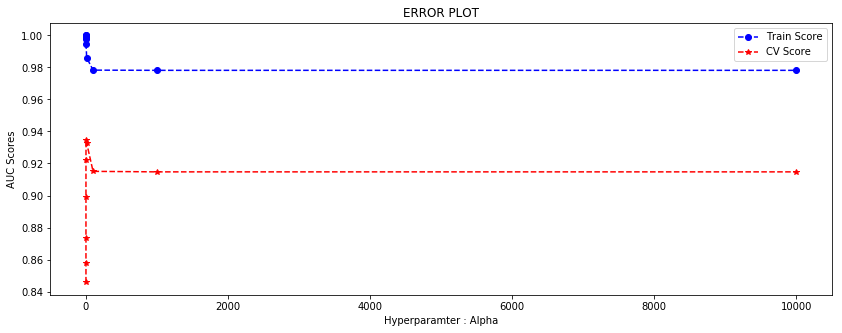

The CV auc score for each alpha value is :  [0.846 0.858 0.873 0.899 0.922 0.935 0.933 0.915 0.915 0.915]
the Train auc score for each alpha value is :  [1.    1.    1.    0.999 0.998 0.995 0.986 0.978 0.978 0.978]


In [45]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(14,5))
plt.title("ERROR PLOT")
plt.xlabel('Hyperparamter : Alpha')
plt.ylabel('AUC Scores')
# mean_train_score is to get mean value of all the error scores we got during cross validation
# cv_results_  = returns a dictionary of all the evaluation metrics from the gridsearch
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV auc score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train auc score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [5.5] Plotting ROC curve and finding AUC score for BoW with L2 regularization

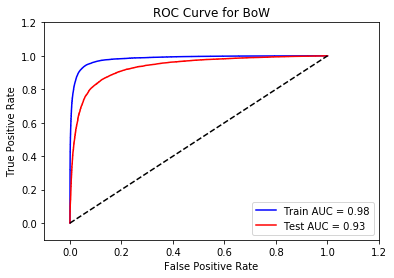

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

model_svm = CalibratedClassifierCV(base_estimator = model, method='sigmoid')
Y_prob = model_svm.fit(X_train_bow_std, Y_train)


train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(X_train_bow_std)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(X_test_bow_std)[:,1])

roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)

# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for BoW')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-  

From the ROC plot, we got the Train AUC of 0.98 and Test AUC of 0.93 , which shows that the classifier is working well and predicts correctly.

### [5.6] Confusion matrix for BoW (L2 reg)

### Train data confusion Matrix

In [47]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_bow_train = sgd_optimal.predict(X_train_bow_std)
cm = confusion_matrix(Y_train, pred_bow_train)
print(cm)

Train confusion matrix
[[26866  1204]
 [  928 27002]]


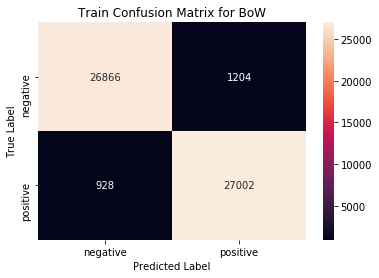

In [48]:
# plot confusion matrix for BoW Train data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_bow_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 26866      FP - 1204

FN - 928 ,      TP - 27002

where

TN - True negative, True value is negative, and is predicted value is negative. 

FP - False positive, True value is negative, but is predicted as positive. 

FN - False negative, True value is positive, but is predicted as negative 

TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 56000 training points being tested against the model. Out of all values, the classifier/model predicted points as positive 28,206 times and negative 27,794 times.
2. But in true values, the positive points are 27,930 and negative points are 28,070.
3. The diagonal values (26866 negative points, 27002 positive points) in the confusion matrix are correctly predicted values by the classifier.


### Test data confusion matrix

In [49]:
# Confusion Matrix for Test data
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_bow_test = sgd_optimal.predict(X_test_bow_std)
cm = confusion_matrix(Y_test, pred_bow_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[10279  1651]
 [ 1489 10581]]


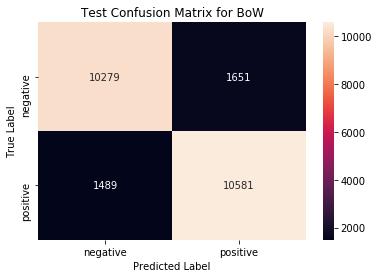

In [50]:
# plot confusion matrix for BoW Test data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_bow_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for BoW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation :-

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 10279  FP - 1651

FN - 1489 , TP - 10581

where

TN - True negative, True value is negative, and is predicted value is negative.

FP - False positive, True value is negative, but is predicted as positive.

FN - False negative, True value is positive, but is predicted as negative

TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 24000 training points being tested against the model. Out of all values, the classifier/model predicted points as positive 12,232 times and negative 11,768 times.
2. But in true values, the positive points are 12,070 and negative points are 11,930.
3. The diagonal values (10279 negative points, 10581 positive points) in the confusion matrix are correctly predicted values by the classifier.


#### Finding TPR, FPR, TNR, FNR values

1. TPR tells, when it's actually yes and how often does classifier predict yes

   TPR = TP/(TP+FN) . TPR also known as Recall
   

2. FPR tells, when it's actually no, how often does classifier predict yes

   FPR = FP/(FP+TN)
   

3. TNR tells, when it's actually no, how often does classifier predict no

   TNR = TN/(TN+FP)
   

4. FNR tells, When it's actually yes, how often does it predict no

   FNR = FN/(FN+TP)



### [5.7] Classification report for BoW:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)


2. Recall:- It tells, when the points are positive and how often they are predicted positive.

   Recall = TP / (TP + FN)


3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)


4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)



In [51]:
# calculate the classification report for BoW
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_bow)) 
print('Report:')
print(classification_report(Y_test, pred_bow)) 


Accuracy Score: 0.8691666666666666
Report:
             precision    recall  f1-score   support

          0       0.87      0.86      0.87     11930
          1       0.87      0.88      0.87     12070

avg / total       0.87      0.87      0.87     24000



### [5.8] Feature Importance for BoW

To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

So we can say that, in SVM we can find feature importance based on absolute value of feature weights.


In [52]:
# Just printing feature names
feature_names = np.array(count_vect.get_feature_names())

model = SGDClassifier()
model.fit(X_train_bow, Y_train)

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['disappointing' 'worst' 'terrible' 'hopes' 'yuck' 'awful'
 'disappointment' 'ruined' 'horrible' 'cancelled']

Largest Coefs: 
['pleasantly' 'worried' 'delicious' 'worry' 'skeptical' 'perfect'
 'awesome' 'downside' 'yummy' 'thank']



In [53]:
def show_most_informative_features(vectorizer, model, n=10): # To print top 10 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) # fns- feature names
    top = zip(coefs_with_fns[:-(n + 1):-1], coefs_with_fns[:n]) 
    for (coef_1, fn_1), (coef_0, fn_0) in top:  # For positive and negative classes to print top 10 features
        print("\t%.4f \t%-15s \t\t%.4f \t%-15s" % (coef_1, fn_1, coef_0, fn_0))
show_most_informative_features(count_vect, model)


	2.0641 	pleasantly      		-2.5623 	disappointing  
	1.7794 	worried         		-2.5267 	worst          
	1.6726 	delicious       		-2.2064 	terrible       
	1.6014 	worry           		-2.0285 	hopes          
	1.6014 	skeptical       		-1.9929 	yuck           
	1.6014 	perfect         		-1.8861 	awful          
	1.5658 	awesome         		-1.8505 	disappointment 
	1.5303 	downside        		-1.7082 	ruined         
	1.5303 	yummy           		-1.6726 	horrible       
	1.4947 	thank           		-1.6370 	cancelled      


# L1 Regularization for BoW

### [5.9] Building a sparse SGDClassifier by performing GridSearchCV on BoW using L1 Regularization

In [54]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}] 

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l1', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(X_train_bow_std, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 0.0001


In [55]:
# get the score on test data 
print(model.score(X_test_bow_std, Y_test))  


0.8461567824182905


### [5.10] Predicting Test score and Test error

In [56]:
# Predicting model on test data to find AUC-score for L1 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(X_train_bow_std, Y_train)

# predict the response
pred_bow = sgd_optimal.predict(X_test_bow_std)

# evaluate accuracy. Using f1_score as metric to measure accuracy, pos_label = 'positive',
test_auc_bow = roc_auc_score(Y_test, pred_bow, average = 'weighted') * float(100)
print('\nThe test AUC score of the BoW SGDclassifier with L1 reg for optimal alpha is %f%%' % (test_auc_bow))



The test AUC score of the BoW SGDclassifier with L1 reg for optimal alpha is 80.674742%


In [57]:
# Finding test error
test_error_bow = (1 - roc_auc_score(Y_test, pred_bow, average = 'weighted')) 
print("Test Error for SGDclassifier BoW with L1 reg is %.3f%%" % (test_error_bow))

Test Error for SGDclassifier BoW with L1 reg is 0.193%


### [5.11] Plotting the performance of Train and CV scores for BoW L1 regularization

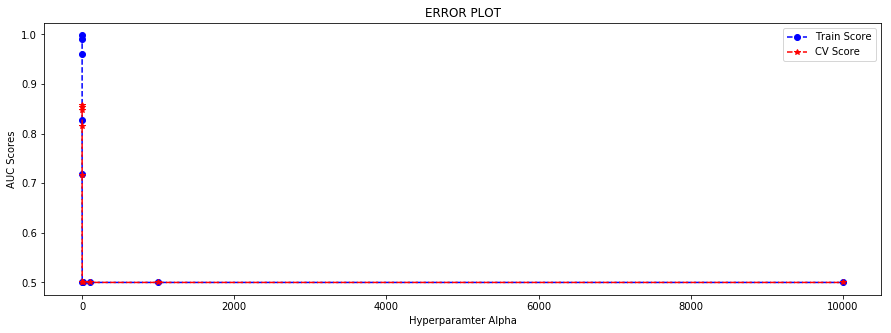

The CV AUC score for each alpha value is :  [0.853 0.857 0.847 0.815 0.717 0.5   0.5   0.5   0.5   0.5  ]
the Train AUC score for each alpha value is :  [0.998 0.99  0.961 0.828 0.719 0.501 0.5   0.5   0.5   0.5  ]


In [58]:
# Plotting the performance of CV and Train scores which we got through L1 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT")
plt.xlabel('Hyperparamter Alpha')
plt.ylabel('AUC Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


# 6. TF-IDF

In [59]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("the type of TFIDF vectorizer ",type(X_train_tfidf))
print("the type of TFIDF vectorizer ",type(X_test_tfidf))

print(X_train_tfidf.get_shape())
print(X_test_tfidf.get_shape())

print("the number of unique words ", X_train_tfidf.get_shape()[1])
print("the number of unique words ", X_test_tfidf.get_shape()[1])


the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(56000, 1148335)
(24000, 1148335)
the number of unique words  1148335
the number of unique words  1148335


### Standardizing the data

In [60]:
from sklearn.preprocessing import StandardScaler
# Standardize the data
scalar = StandardScaler(with_mean=False)
X_train_tfidf_std = scalar.fit_transform(X_train_tfidf)
X_test_tfidf_std = scalar.transform(X_test_tfidf)

print("Final shape of matrix", X_train_tfidf_std.shape)
print("Final shape of matrix", X_test_tfidf_std.shape)


Final shape of matrix (56000, 1148335)
Final shape of matrix (24000, 1148335)


In [61]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

1148335

In [62]:
print("some sample features(unique words in the corpus) are:")
features[50000:50010]

some sample features(unique words in the corpus) are:


['ashy drop',
 'ashy flavor',
 'ashy somewhat',
 'asia',
 'asia also',
 'asia americans',
 'asia big',
 'asia bought',
 'asia box',
 'asia byan']

In [63]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(X_train_tfidf[1,:].toarray()[0],features,20)

In [64]:
top_tfidf

,feature,tfidf
0,nights tea,0.281174
1,thanks available,0.281174
2,sweetner great,0.281174
3,milk agave,0.271031
4,winter nights,0.271031
5,agave sweetner,0.271031
6,find thanks,0.263835
7,great winter,0.263835
8,tea hard,0.234350
9,tea milk,0.230770


## Implementing Linear Kernel using SGDClassifier on TF-IDF

### [6.1] Performing GridSearchCV with SGDClassifier on TF-IDF using f1-score as metric and L2 regularization

In [65]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} 

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, cv=5, scoring = 'roc_auc', n_jobs = -1)

model.fit(X_train_tfidf_std, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=10, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 10


In [67]:
# get the score on test data 
print(model.score(X_test_tfidf_std, Y_test))  


0.9556626197697006


### [6.2] Predicting Test score and Test error for TF-IDF L2 reg

In [68]:
# Predicting model on test data to find f1-score for L2 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(X_train_tfidf_std, Y_train)

# predict the response
pred_tfidf = sgd_optimal.predict(X_test_tfidf_std)

# evaluate accuracy. Using f1_score as metric to measure accuracy, pos_label = 'positive',
test_auc_tfidf = roc_auc_score(Y_test, pred_tfidf, average = 'weighted') * float(100)
print('\nThe test AUC-score of the TF-IDF SGDclassifier with L2 reg for optimal alpha is %f%%' % (test_auc_tfidf))



The test AUC-score of the TF-IDF SGDclassifier with L2 reg for optimal alpha is 88.425033%


In [69]:
# Finding test error
test_error_tfidf = (1 - roc_auc_score(Y_test, pred_tfidf, average = 'weighted')) 
print("Test Error for SGDclassifier TF-IDF with L2 reg is %.3f%%" % (test_error_tfidf))

Test Error for SGDclassifier TF-IDF with L2 reg is 0.116%


### [6.3] Plotting the performance of Train and CV scores for TFIDF with L2 regularization 

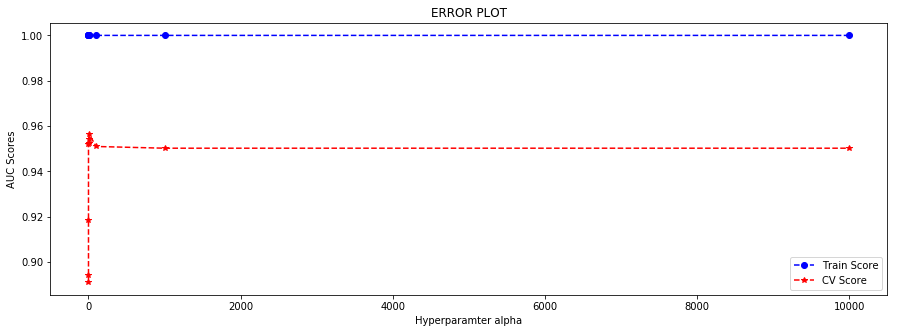

The CV AUC score for each alpha value is :  [0.891 0.894 0.919 0.952 0.953 0.954 0.956 0.951 0.95  0.95 ]
the Train AUC score for each alpha value is :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [70]:
plt.figure(figsize=(15,5))
plt.title("ERROR PLOT")
plt.xlabel('Hyperparamter alpha')
plt.ylabel('AUC Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### [6.4] Plotting ROC curve and finding AUC score for TFIDF L2 reg

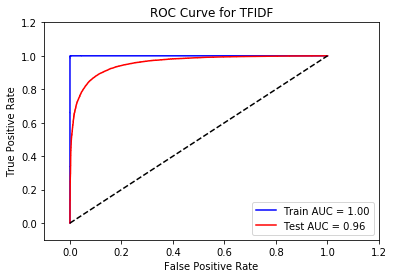

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

model_svm = CalibratedClassifierCV(base_estimator = model, method='sigmoid')
Y_prob = model_svm.fit(X_train_tfidf_std, Y_train)


train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(X_test_tfidf_std)[:,1])

roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)

# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for TFIDF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [6.5] Confusion matrix for TFIDF Train data 

In [72]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_tfidf_train = sgd_optimal.predict(X_train_tfidf_std)
cm = confusion_matrix(Y_train, pred_tfidf_train)
print(cm)

Train confusion matrix
[[28048    22]
 [  103 27827]]


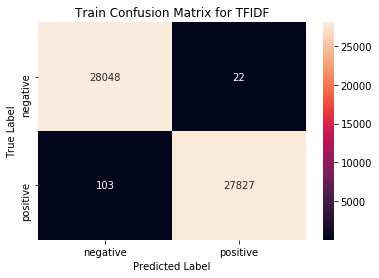

In [73]:
# plot confusion matrix for BoW Train data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_tfidf_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 28048  FP - 22

FN - 103 ,  TP - 27827

where

TN - True negative, True value is negative, and is predicted value is negative. 

FP - False positive, True value is negative, but is predicted as positive. 

FN - False negative, True value is positive, but is predicted as negative 

TP - True positive, True value is positive, and is predicted value is positive.

1. te are total of 30000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 14,931 times and negative 15,069 times. But in true values(test data), the positive points are 15,003 and negative points are 14,997. The diagonal values (13321 negative points, 13255 positive points) in the confusion matrix are correctly predicted values by the classifier.


### [6.6]  Confusion matrix for TFIDF  Test data

In [74]:
# Confusion matrix for Test data
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_tfidf_test = sgd_optimal.predict(X_test_tfidf_std)
cm = confusion_matrix(Y_test, pred_tfidf_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[10635  1295]
 [ 1484 10586]]


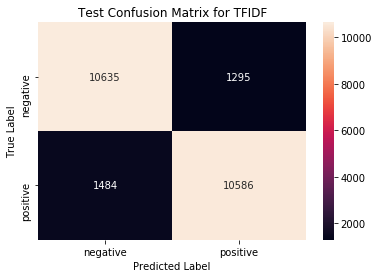

In [75]:
# plot confusion matrix for BoW
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for TFIDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [6.6] Classification report for TFIDF:-

Classification Rate/Accuracy:

Accuracy = (TP + TN) / (TP + TN + FP + FN)

Recall:- It tells, when the points are positive and how often they are predicted positive.

Recall = TP / (TP + FN)

Precision:- It tells, when the model predicted positive and how often is it correct.

Precision = TP / (TP + FP)

f1-score = (2 Recall Precision) / (Recall + Presision)

Support is the total number of points in each class (positive and negative)


In [76]:
# calculate the classification report for TFIDF
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf)) 


Accuracy Score: 0.8842083333333334
Report:
             precision    recall  f1-score   support

          0       0.88      0.89      0.88     11930
          1       0.89      0.88      0.88     12070

avg / total       0.88      0.88      0.88     24000



### [6.7] Feature Importance for TFIDF

To find feature Importance, first sort all the words based on its absolute value of feature weight score, where top words have more weight. So for positive class or negative class, we have to find words with highest absolute weight value, as they are most informative/important features or words for determining whether the text/sentence belongs to positive class or negative class.

If the weight value of a word is positive and large then probability that the word/feature belongs to positive class increases. If the weight value of a word is negative and large then probability that the word/feature belongs to negative class increases.

So we can say that, in SVM we can find feature importance based on absolute value of feature weights.


In [77]:
feature_names = np.array(tf_idf_vect.get_feature_names())

model = SGDClassifier()
model.fit(X_train_tfidf, Y_train)

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['not' 'disappointed' 'worst' 'not good' 'awful' 'terrible'
 'disappointing' 'thought' 'bad' 'not buy']

Largest Coefs: 
['great' 'best' 'delicious' 'good' 'perfect' 'love' 'loves' 'excellent'
 'nice' 'favorite']



In [78]:
# Reference:--  https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, model, n=10): # To print top 10 features 
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names)) # fns- feature names
    top = zip(coefs_with_fns[:-(n + 1):-1], coefs_with_fns[:n]) 
    for (coef_1, fn_1), (coef_0, fn_0) in top:  # For positive and negative classes to print top 10 features
        print("\t%.4f \t%-15s \t\t%.4f \t%-15s" % (coef_1, fn_1, coef_0, fn_0))
show_most_informative_features(tf_idf_vect, model)


	8.0261 	great           		-7.3698 	not            
	6.1743 	best            		-5.3935 	disappointed   
	5.5137 	delicious       		-3.8364 	worst          
	5.2652 	good            		-3.7669 	not good       
	5.1035 	perfect         		-3.5098 	awful          
	4.8246 	love            		-3.5066 	terrible       
	4.4689 	loves           		-3.4329 	disappointing  
	4.2727 	excellent       		-3.3978 	thought        
	3.8886 	nice            		-3.3764 	bad            
	3.7049 	favorite        		-3.3715 	not buy        


# L1 Regularization for TFIDF

### [6.8] Building a sparse SGDClassifier by performing GridSearchCV on TFIDF using L1 Regularization

In [79]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l1', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, cv=5, scoring = 'roc_auc', n_jobs = -1)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(X_train_tfidf_std, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 1e-05


In [80]:
# get the score on test data 
print(model.score(X_test_tfidf_std, Y_test))  

0.7769633931987965


### [6.9] Predicting Test score and Test error for TFIDF with L1 reg

In [81]:
# Predicting model on test data to find AUC-score for L2 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(X_train_tfidf_std, Y_train)

# predict the response
pred_tfidf = sgd_optimal.predict(X_test_tfidf_std)

# evaluate accuracy. Using f1_score as metric to measure accuracy, pos_label = 'positive',
test_auc_tfidf = roc_auc_score(Y_test, pred_tfidf, average = 'weighted') * float(100)
print('\nThe test AUC-score of the TFIDF SGDclassifier with L1 reg for optimal alpha is %f%%' % (test_auc_tfidf))



The test AUC-score of the TFIDF SGDclassifier with L1 reg for optimal alpha is 73.239492%


In [82]:
# Finding test error
test_error_tfidf = (1 - roc_auc_score(Y_test, pred_tfidf, average = 'weighted')) 
print("Test Error for SGDclassifier TFIDF L1 reg is %.3f%%" % (test_error_tfidf))

Test Error for SGDclassifier TFIDF L1 reg is 0.268%


### [6.10] Plotting the performance of Train and CV scores for TFIDF  L1 regularization

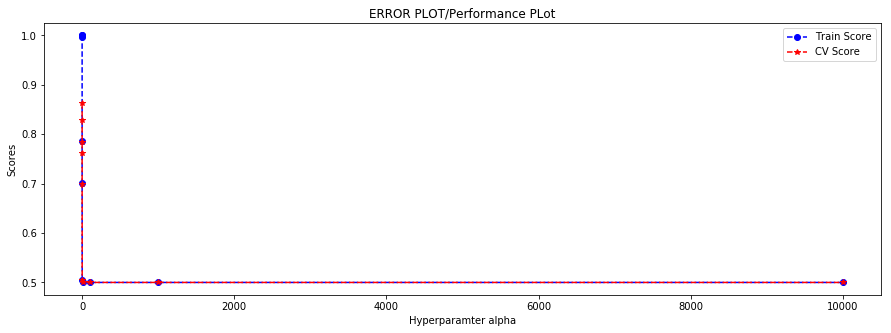

The CV AUC-score for each alpha value is :  [0.863 0.829 0.785 0.761 0.698 0.504 0.5   0.5   0.5   0.5  ]
the Train AUC score for each alpha value is :  [1.    1.    0.997 0.786 0.701 0.504 0.5   0.5   0.5   0.5  ]


In [83]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT/Performance PLot")
plt.xlabel('Hyperparamter alpha')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


# 7. Word2Vec

In [84]:
# I am Training Word2Vec model using Amazon fine food text corpus
# This is W2V for Train data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [86]:
# One sentence is converted into a list
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

get combing cheerios honey smacks peanuts get actually sounds good unfortunately combination flavors okay not great not sure even good weird cloying aftertaste cereal feels dry individual pieces large crunchy not kidlets think okay prefer honey nut cheerios even raisin bran fave not good signbottom line ymmv not replacing box another one
*****************************************************************
['get', 'combing', 'cheerios', 'honey', 'smacks', 'peanuts', 'get', 'actually', 'sounds', 'good', 'unfortunately', 'combination', 'flavors', 'okay', 'not', 'great', 'not', 'sure', 'even', 'good', 'weird', 'cloying', 'aftertaste', 'cereal', 'feels', 'dry', 'individual', 'pieces', 'large', 'crunchy', 'not', 'kidlets', 'think', 'okay', 'prefer', 'honey', 'nut', 'cheerios', 'even', 'raisin', 'bran', 'fave', 'not', 'good', 'signbottom', 'line', 'ymmv', 'not', 'replacing', 'box', 'another', 'one']


In [87]:
# Train the word2vec model for Train data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_train = gensim.models.Word2Vec(list_of_sent_train, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_train = list(w2v_model_train.wv.vocab)
print(len(words_train))

# prints 50 words
print("sample words ", words_train[0:50])

15611
sample words  ['get', 'combing', 'cheerios', 'honey', 'smacks', 'peanuts', 'actually', 'sounds', 'good', 'unfortunately', 'combination', 'flavors', 'okay', 'not', 'great', 'sure', 'even', 'weird', 'cloying', 'aftertaste', 'cereal', 'feels', 'dry', 'individual', 'pieces', 'large', 'crunchy', 'think', 'prefer', 'nut', 'raisin', 'bran', 'fave', 'line', 'ymmv', 'replacing', 'box', 'another', 'one', 'favorite', 'tea', 'milk', 'agave', 'sweetner', 'winter', 'nights', 'hard', 'find', 'thanks', 'available']


In [88]:
w2v_model_train.wv.most_similar('family')

[('household', 0.7572441101074219),
 ('members', 0.7124148607254028),
 ('friends', 0.7012181878089905),
 ('mom', 0.6975873708724976),
 ('guests', 0.6468737721443176),
 ('hubby', 0.6414618492126465),
 ('daughters', 0.6396790742874146),
 ('parties', 0.6380088925361633),
 ('husband', 0.6242074370384216),
 ('grandson', 0.6210526823997498)]

In [89]:
# This is W2V for Test data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    

In [90]:
# One sentence is converted into a list
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

tiny pieces white chocolate simply delicious wish package buttons definitely one favorite candies musttry delight
*****************************************************************
['tiny', 'pieces', 'white', 'chocolate', 'simply', 'delicious', 'wish', 'package', 'buttons', 'definitely', 'one', 'favorite', 'candies', 'musttry', 'delight']


In [91]:
# Train the word2vec model for Test data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

# prints 50 words
print("sample words ", words_test[0:50])

10253
sample words  ['tiny', 'pieces', 'white', 'chocolate', 'simply', 'delicious', 'wish', 'package', 'buttons', 'definitely', 'one', 'favorite', 'candies', 'delight', 'plant', 'several', 'months', 'sorry', 'see', 'no', 'longer', 'offered', 'brussel', 'amazon', 'sent', 'friends', 'order', 'love', 'mine', 'arrived', 'healthy', 'remained', 'originally', 'ordered', 'received', 'two', 'red', 'envelope', 'quite', 'sickly', 'gifts', 'return', 'pleased', 'lucky', 'bamboo', 'also', 'thriving', 'later', 'highly', 'recommend']


## [7.1] Avg-Word2Vec

We take the average of all word2vec(vector) representations of all words in a review and divide them by number of words in a review. This is vector representation of a review. 

In [92]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            vec = w2v_model_train.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_train.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

56000
50


In [93]:
# average Word2Vec for Test data
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

24000
50


### [7.2] Performing GridSearch CV on AvgW2V using f1-score as metric using L2 regularization

In [94]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 0.0001


In [104]:
# get the score on test data 
print(model.score(sent_vectors_test, Y_test))  


0.8553041284043694


### 7.3 Predicting Test score and Test error for AvgW2V L2  reg

In [105]:
# Predicting model on test data to find auc-score for L2 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(sent_vectors_train, Y_train)

# predict the response
pred_w2v = sgd_optimal.predict(sent_vectors_test)

# evaluate accuracy. Using f1_score as metric to measure accuracy, pos_label = 'positive',
test_auc_w2v = roc_auc_score(Y_test, pred_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the SGDclassifier AVGW2V with L2 reg for optimal alpha is %f%%' % (test_auc_w2v))




The test AUC-score of the SGDclassifier AVGW2V with L2 reg for optimal alpha is 74.263590%


In [106]:
# Finding test error
test_error_w2v = (1 - roc_auc_score(Y_test, pred_w2v, average = 'weighted')) 
print("Test Error for SGDclassifier AVGW2V with L2 reg is %.3f%%" % (test_error_w2v))

Test Error for SGDclassifier AVGW2V with L2 reg is 0.257%


### 7.4 Plotting the performance of Train and CV scores for AvgW2V

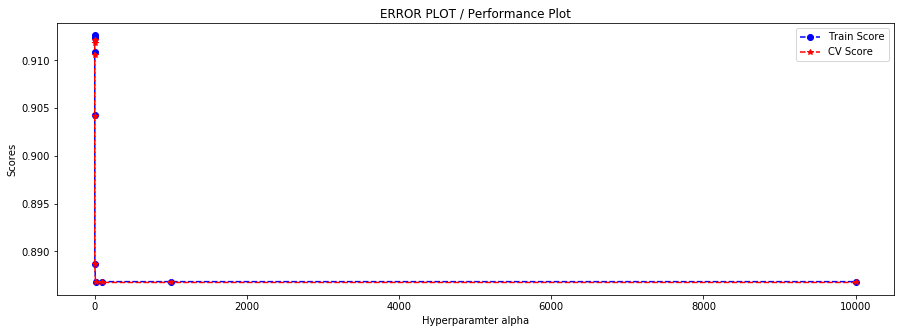

The CV AUC-score for each alpha value is :  [0.912 0.912 0.912 0.911 0.904 0.889 0.887 0.887 0.887 0.887]
the Train AUC score for each alpha value is :  [0.912 0.913 0.913 0.911 0.904 0.889 0.887 0.887 0.887 0.887]


In [107]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT / Performance Plot")
plt.xlabel('Hyperparamter alpha')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### 7.5 Plotting ROC curve and finding AUC score for AvgW2V L2 reg

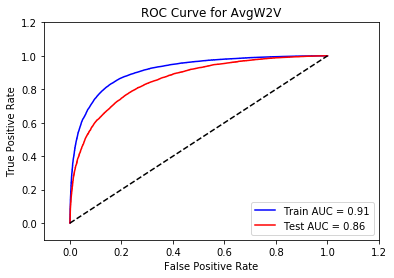

In [108]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

model_svm = CalibratedClassifierCV(base_estimator = model, method='sigmoid')
Y_prob = model_svm.fit(sent_vectors_train, Y_train)


train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(sent_vectors_test)[:,1])

roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)

# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for AvgW2V')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 7.6 Confusion matrix for AvgW2V Train data

In [109]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_w2v_train = sgd_optimal.predict(sent_vectors_train)
cm = confusion_matrix(Y_train, pred_w2v_train)
print(cm)

Train confusion matrix
[[25636  2434]
 [ 8877 19053]]


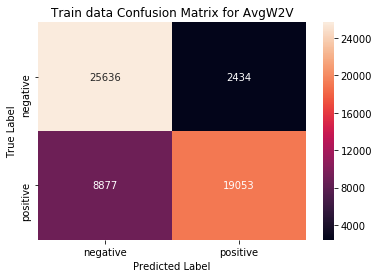

In [110]:
# plot confusion matrix for AvgW2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_w2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train data Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 7.7 Confusion matrix for AvgW2V Test data

In [111]:
# Confusion matrix for Test data
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_w2v_test = sgd_optimal.predict(sent_vectors_test)
cm = confusion_matrix(Y_test, pred_w2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[8115 3815]
 [2353 9717]]


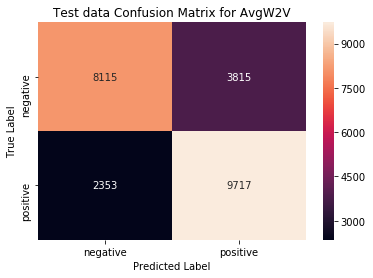

In [112]:
# plot confusion matrix for AvgW2V Test data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_w2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test data Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 7.8 Classification report for AvgW2V:-

Classification Rate/Accuracy:

Accuracy = (TP + TN) / (TP + TN + FP + FN)

Recall:- It tells, when the points are positive and how often they are predicted positive.

Recall = TP / (TP + FN)

Precision:- It tells, when the model predicted positive and how often is it correct.

Precision = TP / (TP + FP)

f1-score = (2 Recall Precision) / (Recall + Presision)

Support is the total number of points in each class (positive and negative)


In [113]:
# calculate the classification report for AvgW2V
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_w2v)) 


Accuracy Score: 0.743
Report:
             precision    recall  f1-score   support

          0       0.78      0.68      0.72     11930
          1       0.72      0.81      0.76     12070

avg / total       0.75      0.74      0.74     24000



## 7.9 L1 Regularization for AvgW2V

### 7.10 Building a sparse SGDClassifier by performing GridSearchCV on AvgW2V using L1 Regularization

In [114]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l1', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, cv=5, scoring = 'roc_auc', n_jobs = -1)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 0.0001


In [115]:
# get the score on test data 
print(model.score(sent_vectors_test, Y_test))  


0.8552324801330045


### 7.11 Predicting Test score and Test error for AvgW2V with L1 reg

In [116]:
# Predicting model on test data to find AUC-score for L1 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(sent_vectors_train, Y_train)

# predict the response
pred_w2v = sgd_optimal.predict(sent_vectors_test)

# evaluate accuracy. Using AUC_score as metric to measure accuracy
test_auc_w2v = roc_auc_score(Y_test, pred_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the SGDclassifier AvgW2V L1 reg for optimal alpha is %f%%' % (test_auc_w2v))



The test AUC-score of the SGDclassifier AvgW2V L1 reg for optimal alpha is 75.224174%


In [117]:
# Finding test error
test_error_w2v = (1 - roc_auc_score(Y_test, pred_w2v, average = 'weighted')) 
print("Test Error for SGDclassifier AvgW2V L1 reg is %.3f%%" % (test_error_w2v))

Test Error for SGDclassifier AvgW2V L1 reg is 0.248%


### 7.12 Plotting the performance of Train and CV scores for L1 regularization

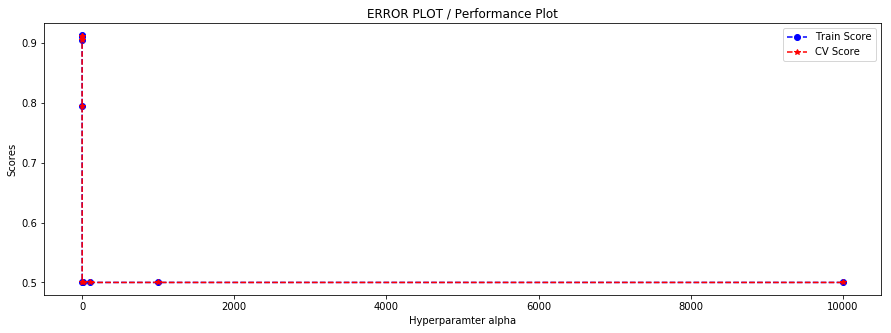

The CV AUC-score for each alpha value is :  [0.912 0.912 0.912 0.905 0.795 0.5   0.5   0.5   0.5   0.5  ]
the Train AUC score for each alpha value is :  [0.912 0.913 0.912 0.905 0.795 0.5   0.5   0.5   0.5   0.5  ]


In [118]:
# Plotting the performance of CV and Train scores which we got through L1 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT / Performance Plot")
plt.xlabel('Hyperparamter alpha')
plt.ylabel('Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


# 8. TFIDF-W2V

In [119]:
model = TfidfVectorizer()
tfidf_train_matrix = model.fit_transform(X_train)
tfidf_test_matrix = model.transform(X_test)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [120]:
print(tfidf_train_matrix.get_shape()) 
print(tfidf_test_matrix.get_shape()) 


(56000, 82212)
(24000, 82212)


In [121]:
# TF-IDF weighted Word2Vec for Train data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            try:
                vec = w2v_model_train.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 56000/56000 [03:48<00:00, 245.45it/s]


In [122]:
# TF-IDF weighted Word2Vec for Test data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            try:
                vec = w2v_model_test.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            #tf_idf = tfidf_test_matrix[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 24000/24000 [01:01<00:00, 392.26it/s]


### 8.1 Applying Linear Kernel using SGDClassifier on TFIDF-W2V with L2 Regularization

In [123]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]} 

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)

# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(tfidf_sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 0.0001


In [124]:
# get the score on test data 
print(model.score(tfidf_sent_vectors_test, Y_test))  


0.8284413740467558


### 8.2  Predicting Test score and Test error for TFIDF-W2V with L2 reg

In [125]:
# Predicting model on test data to find AUC-score for L2 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
pred_tfidf_w2v = sgd_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy. Using auc_score as metric to measure accuracy.
test_auc_tfidf_w2v = roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the SGDclassifier TFIDF-W2V with L2 reg for optimal alpha is %f%%' % (test_auc_tfidf_w2v))



The test AUC-score of the SGDclassifier TFIDF-W2V with L2 reg for optimal alpha is 72.425701%


In [126]:
# Finding test error
test_error_tfidf_w2v = (1 - roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted')) 
print("Test Error for SGDclassifier TFIDF-W2V L2 reg is %.3f%%" % (test_error_tfidf_w2v))

Test Error for SGDclassifier TFIDF-W2V L2 reg is 0.276%


### 8.3 Plotting the performance of Train and CV scores for L2 regularization TFIDF-W2V

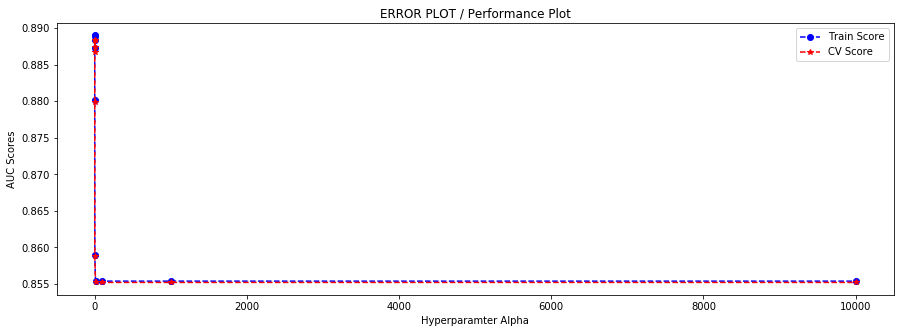

The CV AUC-score for each alpha value is :  [0.887 0.888 0.888 0.887 0.88  0.859 0.855 0.855 0.855 0.855]
the Train AUC score for each alpha value is :  [0.888 0.889 0.889 0.887 0.88  0.859 0.855 0.855 0.855 0.855]


In [127]:
# Plotting the performance of CV and Train scores which we got through L2 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT / Performance Plot")
plt.xlabel('Hyperparamter Alpha')
plt.ylabel('AUC Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


### 8.4 Plotting ROC curve and finding AUC score for TFIDF-W2V

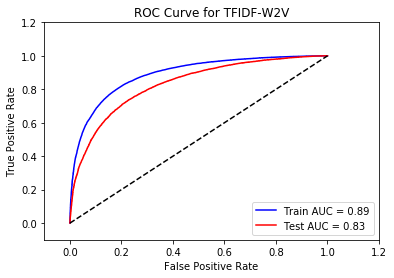

In [128]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

model_svm = CalibratedClassifierCV(base_estimator = model, method='sigmoid')
Y_prob = model_svm.fit(tfidf_sent_vectors_train, Y_train)


train_fpr, train_tpr, thresholds = roc_curve(Y_train, Y_prob.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, Y_prob.predict_proba(tfidf_sent_vectors_test)[:,1])

roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)

# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for TFIDF-W2V')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### 8.5 Confusion matrix for TFIDF-W2V  Train Data

In [129]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix for TFIDF-W2V")
pred_tfidf_w2v_train = sgd_optimal.predict(tfidf_sent_vectors_train)
cm = confusion_matrix(Y_train, pred_tfidf_w2v_train)
print(cm)

Train confusion matrix for TFIDF-W2V
[[22500  5570]
 [ 5824 22106]]


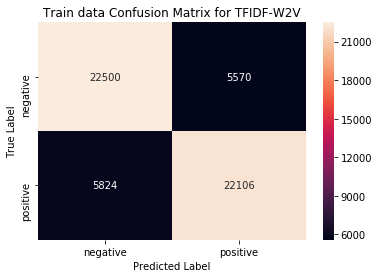

In [130]:
# plot confusion matrix for TFIDF-W2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train, pred_tfidf_w2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train data Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 8.6 Confusion matrix for TFIDF-W2V Test data

In [131]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix for TFIDF-W2V")
pred_tfidf_w2v_test = sgd_optimal.predict(tfidf_sent_vectors_test)
cm = confusion_matrix(Y_test, pred_tfidf_w2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix for TFIDF-W2V
[[7973 3957]
 [2653 9417]]


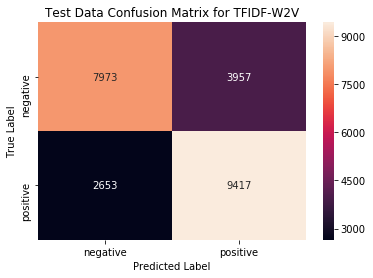

In [132]:
# plot confusion matrix for TFIDF-W2V
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test, pred_tfidf_w2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Data Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 8.7 Classification report for TFIDF-W2V

In [133]:
# calculate the classification report for TFIDF-W2V
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test, pred_tfidf_w2v)) 
print('Report:')
print(classification_report(Y_test, pred_tfidf_w2v)) 


Accuracy Score: 0.7245833333333334
Report:
             precision    recall  f1-score   support

          0       0.75      0.67      0.71     11930
          1       0.70      0.78      0.74     12070

avg / total       0.73      0.72      0.72     24000



## 8.8 L1 Regularization for TFIDF-W2V

### 8.9 Building a sparse SGDClassifier by performing GridSearchCV on TFIDF-W2V using L1 Regularization

In [134]:
# Implementing SGD Classifier with Hinge loss to get Linear SVM.
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Using GridSearchCV. Default regularizer is L2. We can change it to L1 using penalty = 'L1'
#Now using GridSearchCV, SGD classifier is trained on these list of hyperparameters/values of C.
# Scoring is taken as f1_macro.
model = GridSearchCV(SGDClassifier(loss = 'hinge', penalty = 'l1', max_iter = 1000, class_weight = 'balanced'), tuned_parameters, cv=5, scoring = 'roc_auc', n_jobs = -1)
# model = linear_model.SGDClassifier(loss = 'hinge', penalty = 'l2', tuned_parameters, scoring = 'f1_macro', cv=5, max_iter = 1000)

model.fit(tfidf_sent_vectors_train, Y_train)

print("Model with best parameters is :\n", model.best_estimator_)
optimal_alpha =  model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is :", optimal_alpha)

Model with best parameters is :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
The optimal value of alpha(1/C) is : 0.0001


In [135]:
# get the score on test data 
print(model.score(tfidf_sent_vectors_test, Y_test))  


0.8286473880013973


### 8.10 Predicting Test score and Test error for TFIDF-W2V with L1 reg

In [138]:
# Predicting model on test data to find AUC-score for L1 Regularization

sgd_optimal = SGDClassifier(alpha = optimal_alpha)

# fitting the model
sgd_optimal.fit(tfidf_sent_vectors_train, Y_train)

# predict the response
pred_tfidf_w2v = sgd_optimal.predict(tfidf_sent_vectors_test)

# evaluate accuracy. Using AUC_score as metric to measure accuracy
test_auc_tfidf_w2v = roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted') * float(100)
print('\nThe test AUC-score of the SGDclassifier TFIDF-W2V with L1 reg for optimal alpha is %f%%' % (test_auc_tfidf_w2v))



The test AUC-score of the SGDclassifier TFIDF-W2V with L1 reg for optimal alpha is 73.334742%


In [139]:
# Finding test error
test_error_tfidf_w2v = (1 - roc_auc_score(Y_test, pred_tfidf_w2v, average = 'weighted')) 
print("Test Error for SGDclassifier TFIDF-W2V L1-reg is %.3f%%" % (test_error_tfidf_w2v))

Test Error for SGDclassifier TFIDF-W2V L1-reg is 0.267%


### 8.11 Plotting the performance of Train and CV scores for L1 regularization TFIDF-W2V

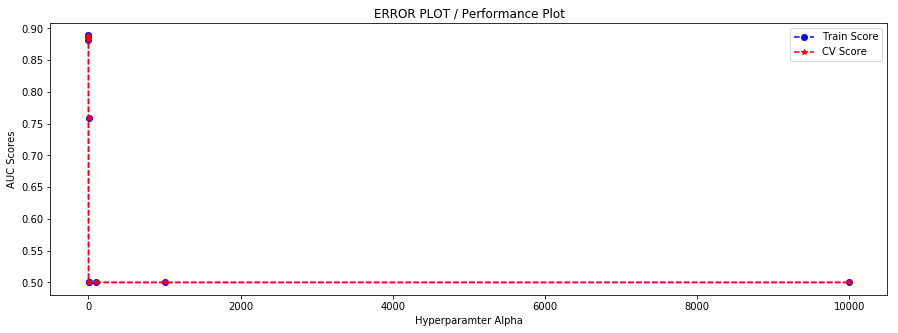

The CV AUC-score for each alpha value is :  [0.888 0.888 0.888 0.882 0.758 0.5   0.5   0.5   0.5   0.5  ]
the Train AUC score for each alpha value is :  [0.888 0.889 0.889 0.882 0.758 0.5   0.5   0.5   0.5   0.5  ]


In [140]:
# Plotting the performance of CV and Train scores which we got through L1 regularization

plt.figure(figsize=(15,5))
plt.title("ERROR PLOT / Performance Plot")
plt.xlabel('Hyperparamter Alpha')
plt.ylabel('AUC Scores')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model.cv_results_['param_alpha'].data.astype(np.float64), model.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each alpha value is : ", np.round(model.cv_results_['mean_test_score'],3))

print("the Train AUC score for each alpha value is : ", np.round(model.cv_results_['mean_train_score'],3))


## 9. Models Summarization

In [147]:
from pandas import DataFrame
LinearSVM = {'Vectorizer':['BoW', 'TFIDF', 'AVG-W2V', 'TFIDF-W2V'], 'Model':['Linear SVM','Linear SVM','Linear SVM','Linear SVM'], 
                       'Hyper parameter Alpha for L1 Reg':['0.0001', '0.00001','0.0001','0.0001'],
                       'AUC-score for L1 Reg':['80.67','73.23','75.22','73.33'],
                       'Test error for L1 Reg':['0.19','0.26','0.24','0.26'],
                       'Hyper parameter Alpha forL2 Reg':['1','10','0.0001','0.0001'],
                       'AUC-score for L2 Reg':['86.91','88.42','74.26','72.42'],
                       'Test error for L2 Reg':['0.13','0.11','0.25','0.27'],
                       'Train AUC Score':['0.98','1.00','0.91','0.89'],
                       'Test AUC Score':['0.93','0.96','0.86','0.83']}
                       

In [148]:
Final_conclusions = DataFrame(LinearSVM)
Final_conclusions

,Vectorizer,Model,Hyper parameter Alpha for L1 Reg,AUC-score for L1 Reg,Test error for L1 Reg,Hyper parameter Alpha forL2 Reg,AUC-score for L2 Reg,Test error for L2 Reg,Train AUC Score,Test AUC Score
0,BoW,Linear SVM,0.0001,80.67,0.19,1,86.91,0.13,0.98,0.93
1,TFIDF,Linear SVM,0.00001,73.23,0.26,10,88.42,0.11,1.00,0.96
2,AVG-W2V,Linear SVM,0.0001,75.22,0.24,0.0001,74.26,0.25,0.91,0.86
3,TFIDF-W2V,Linear SVM,0.0001,73.33,0.26,0.0001,72.42,0.27,0.89,0.83


## [10] Conclusions:-

1. From the above observations we can say that, AUC-score is better for Linear SVM using L2 Regularization for BoW and TFIDF than the other featurizations. 
2. The Train and Test AUC score which I got from ROC curve are good for all featurizations, but are much better for BoW and TFIDF 
3. Out of all 4 featurizations trained by Linear SVM using SGDClassifier with hinge loss, BoW and TFIDF are working well on unseen data.